In [1]:
import numpy as np
import sys
import math
import timeit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import py3Dmol
import matplotlib.pyplot as plt

In [2]:
chignolin2 = Chem.rdmolfiles.MolFromFASTA("GYDPETGTWG")
chignolin2 = Chem.AddHs(chignolin2, explicitOnly=True)

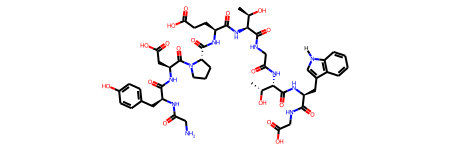

In [3]:
chignolin2

In [46]:
print(Chem.AddHs.__doc__)


AddHs( (Mol)mol [, (bool)explicitOnly=False [, (bool)addCoords=False [, (AtomPairsParameters)onlyOnAtoms=None [, (bool)addResidueInfo=False]]]]) -> Mol :
    Adds hydrogens to the graph of a molecule.
    
      ARGUMENTS:
    
        - mol: the molecule to be modified
    
        - explicitOnly: (optional) if this toggle is set, only explicit Hs will
          be added to the molecule.  Default value is 0 (add implicit and explicit Hs).
    
        - addCoords: (optional) if this toggle is set, The Hs will have 3D coordinates
          set.  Default value is 0 (no 3D coords).
    
        - onlyOnAtoms: (optional) if this sequence is provided, only these atoms will be
          considered to have Hs added to them
    
        - addResidueInfo: (optional) if this is true, add residue info to
          hydrogen atoms (useful for PDB files).
    
      RETURNS: a new molecule with added Hs
    
      NOTES:
    
        - The original molecule is *not* modified.
    
        - Much o

In [6]:
import openmm
import openmm.app as app
import openmm.unit as u

charmm_configs = {
    "chignolin": {
        "toppar": [
            "../idp_rl/environments/environment_components/toppar/par_all36_prot.prm", 
            "../idp_rl/environments/environment_components/toppar/top_all36_prot.rtf",
            "../idp_rl/environments/environment_components/toppar/toppar_water_ions.str",
        ],
        "psf": "../idp_rl/molecule_generation/chignolin/GYDPETGTWG.psf",
    }
}

charmm_config = charmm_configs["chignolin"]
openmm_toppar = app.CharmmParameterSet(*charmm_config["toppar"])
openmm_psf = app.CharmmPsfFile(charmm_config["psf"])
openmm_system = openmm_psf.createSystem(openmm_toppar)

# TODO: test GPU version simulator
integrator = openmm.LangevinMiddleIntegrator(300 * u.kelvin, 1 / u.picosecond, 0.004 * u.picoseconds)

platform = openmm.Platform.getPlatformByName("CPU")
simulator = app.Simulation(openmm_psf.topology, openmm_system, integrator, platform)

In [4]:
# numConfs = 200
chignolin = Chem.MolFromPDBFile("../idp_rl/molecule_generation/chignolin/GYDPETGTWG.pdb", removeHs=False)
# Chem.AllChem.EmbedMultipleConfs(chignolin, numConfs=numConfs)

In [7]:
from rdkit.Geometry import Point3D

def np_to_mm(arr: np.ndarray, unit: openmm.unit=u.angstrom):
    wrapped_val = openmm.unit.quantity.Quantity(arr, unit)
    return wrapped_val

def _optimize_conf(mol: Chem.Mol, conf_id: int = None, **kwargs):
    if conf_id is None:
        conf_id = mol.GetNumConformers() - 1
    conf = mol.GetConformer(conf_id)

    positions = np_to_mm(conf.GetPositions())
    simulator.context.setPositions(positions)
    simulator.minimizeEnergy()#maxIterations=500)

    # CHARMM returns all of its positions in nm, so we have to convert back to Angstroms for RDKit
    optimized_positions_nm = simulator.context.getState(getPositions=True).getPositions()
    optimized_positions = optimized_positions_nm.in_units_of(u.angstrom) # match RDKit/MMFF convention

    for i, pos in enumerate(optimized_positions):
        conf.SetAtomPosition(i, Point3D(pos.x, pos.y, pos.z))

In [9]:
for conf in range(numConfs):
    _optimize_conf(chignolin, conf_id=conf)

In [10]:
from rdkit.Chem import TorsionFingerprints
from rdkit.Chem import rdMolTransforms
from sklearn.manifold import TSNE

phi_atoms = [83, 85, 87, 90]
psi_atoms = [85, 87, 90, 92]

def get_gly7_dihedrals(version_mol):
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(version_mol)
    torsions = [nr[0] for nr in nonring]

    phis = []
    psis = []
    for conf_id in range(version_mol.GetNumConformers()):
        conf = version_mol.GetConformer(conf_id)
        phi = rdMolTransforms.GetDihedralDeg(conf, *phi_atoms)
        psi = rdMolTransforms.GetDihedralDeg(conf, *psi_atoms)
        phis.append(phi)
        psis.append(psi)
    
    return np.array(phis), np.array(psis)

In [11]:
Draw.MolToFile(chignolin,"chig_phi.png",size=(800,800),highlightAtoms=phi_atoms)
Draw.MolToFile(chignolin,"chig_psi.png",size=(800,800),highlightAtoms=psi_atoms)

In [12]:
print([chignolin.GetAtomWithIdx(idx).GetSymbol() for idx in phi_atoms])
print([chignolin.GetAtomWithIdx(idx).GetSymbol() for idx in psi_atoms])

['C', 'N', 'C', 'C']
['N', 'C', 'C', 'N']


In [13]:
phi, psi = get_gly7_dihedrals(chignolin)

(-180.0, 180.0)

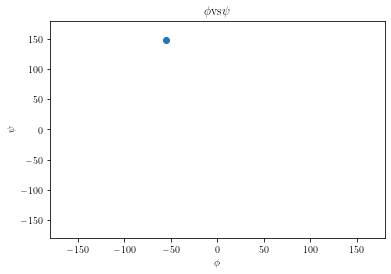

In [14]:
plt.rcParams['text.usetex'] = True
plt.rcParams["axes.grid"] = False

plt.title("$\phi \mathrm{vs} \psi$")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")

plt.scatter(phi, psi)

plt.xlim((-180, 180))
plt.ylim((-180, 180))

In [59]:
size = (500,300)
view = py3Dmol.view(width=size[0], height=size[1])

conf = chignolin.GetConformer(0)

Chem.rdMolTransforms.SetDihedralDeg(conf, *phi_atoms, 70)
Chem.rdMolTransforms.SetDihedralDeg(conf, *psi_atoms, 30)
block = Chem.MolToMolBlock(chignolin, confId=0)
view.addModel(block, 'mol')    

view.setStyle({"stick" : {}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [51]:
from sklearn.cluster import KMeans
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
label = kmeans.fit_predict(dihedrals)

In [51]:
v = py3Dmol.view(style={'cartoon':{},'stick':{}})
v.setHoverable({},True,'''function(atom,viewer,event,container) {
                   if(!atom.label) {
                    atom.label = viewer.addLabel(atom.resn+":"+atom.atom,{position: atom, backgroundColor: 'mintcream', fontColor:'black'});
                   }}''',
               '''function(atom,viewer) { 
                   if(atom.label) {
                    viewer.removeLabel(atom.label);
                    delete atom.label;
                   }
                }''')
view.addModel(block, 'mol')
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

(0.0, 360.0)

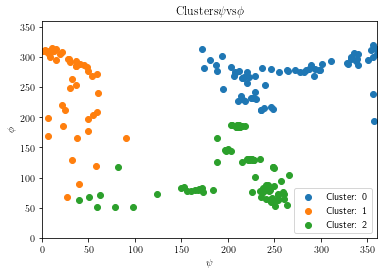

In [52]:
plt.title("$\mathrm{Clusters} \psi \mathrm{vs} \phi$")
plt.xlabel("$\psi$")
plt.ylabel("$\phi$")

for cluster_idx in range(num_clusters):
    plt.scatter(
        dihedrals[label == cluster_idx,0], 
        dihedrals[label == cluster_idx,1],
        label=f"Cluster: {cluster_idx}"
    )

plt.legend()    
plt.xlim((0, 360))
plt.ylim((0, 360))

In [23]:
Chem.rdMolAlign.AlignMolConformers(chignolin)

In [11]:
def drawConformer(mol: Chem.Mol, confIds, size=(300, 300), style="stick"):
    view = py3Dmol.view(width=size[0], height=size[1])
    for confId in confIds:
        block = Chem.MolToMolBlock(mol, confId=confId)
        view.addModel(block, 'mol')
    view.setStyle({style : {}})
    view.zoomTo()
    return view

In [22]:
Chem.rdmolfiles.MolToPDBFile(chignolin, "chig_exp.pdb", confId=-1)

In [ ]:
size = (500,300)
view = py3Dmol.view(width=size[0], height=size[1])

cluster_id = 2
cur_id = 2
num_confs_viz = 5

indices = []

for viz_id in range(cur_id, cur_id + num_confs_viz):
    if viz_id in []:
        continue
    index = int(np.where(label == cluster_id)[0][viz_id])
    indices.append(index)
    block = Chem.MolToMolBlock(chignolin, confId=index)
    view.addModel(block, 'mol')
    
view.setStyle({"stick" : {}})
view.zoomTo()
view.show()

: 

In [33]:
from rdkit.Chem import AllChem
mmff_props = AllChem.MMFFGetMoleculeProperties(chignolin)
energies = []
for i in range(200):
    ff = AllChem.MMFFGetMoleculeForceField(chignolin, mmff_props, confId=i)
    energy = ff.CalcEnergy()
    energies.append(energy)

(array([53., 28., 19.,  9.,  8.,  5.,  6.,  9.,  8.,  5.]),
 array([121.57279817, 200.64982247, 279.72684676, 358.80387106,
        437.88089535, 516.95791965, 596.03494394, 675.11196824,
        754.18899254, 833.26601683, 912.34304113]),
 <BarContainer object of 10 artists>)

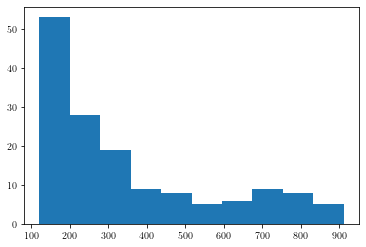

In [32]:
plt.hist(sorted(energies)[:-50])

In [34]:
def tfd_matrix(mol: Chem.Mol) -> np.array:
    """Calculates the TFD matrix for all conformers in a molecule.
    """
    tfd = TorsionFingerprints.GetTFDMatrix(mol, useWeights=False)
    n = int(np.sqrt(len(tfd)*2))+1
    idx = np.tril_indices(n, k=-1, m=n)
    matrix = np.zeros((n,n))
    matrix[idx] = tfd
    matrix += np.transpose(matrix)
    return matrix

matrix = tfd_matrix(chignolin)

<AxesSubplot:>

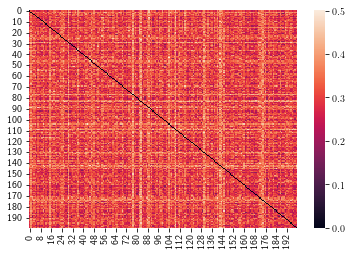

In [38]:
import seaborn as sns
sns.heatmap(matrix)